In [ ]:
# MENTAL HEALTH DISORDER
# BERT base

In [ ]:
# Step 1: Install dependencies
!pip install transformers torch pandas scikit-learn openpyxl matplotlib seaborn tqdm --quiet


In [ ]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # Import AdamW from torch.optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# Step 3: Upload and load dataset
print("📂 Please upload your dataset (MentalHealthTweets.xlsx)")
from google.colab import files
uploaded = files.upload()

import io
file_name = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print("✅ Dataset Loaded Successfully!")
print(df.head())


📂 Please upload your dataset (MentalHealthTweets.xlsx)


Saving MentalHealthTweets.xlsx to MentalHealthTweets.xlsx
✅ Dataset Loaded Successfully!
   Unnamed: 0                                             tweets  label
0           0  be mindful of the timing of your communication...      0
1           1  so why are we suffering disruption today  anxiety      1
2           2  millions of people around the world struggle s...      2
3           3  lets all help to smash the stigma   ptsi  smas...      0
4           4  despair deepens for young people as  pandemic ...      1


In [ ]:
# Step 4: Preprocess dataset
df = df.dropna()
df.columns = df.columns.str.lower()
text_col = 'tweets'
label_col = 'label'

X = df[text_col].astype(str).tolist()
y = df[label_col].astype(int).tolist()

# Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 6: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TweetDataset(X_train, y_train, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Step 7: Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 8: Training
epochs = 2
model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 Loss: 0.7154


Epoch 2 Loss: 0.4072


In [ ]:
# Step 9: Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f" Accuracy: {accuracy*100:.2f}%")

print(" Classification Report:")
print(classification_report(true_labels, predictions))


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  8.54it/s]

✅ Accuracy: 77.64%
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91       168
           1       0.64      0.73      0.69       153
           2       0.83      0.64      0.72       171

    accuracy                           0.78       492
   macro avg       0.78      0.78      0.77       492
weighted avg       0.78      0.78      0.77       492



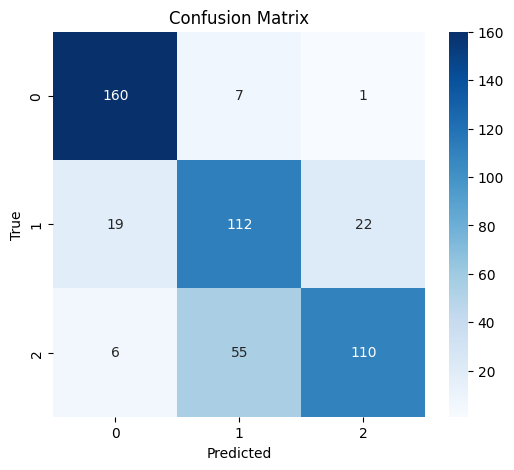

In [ ]:
# Step 10: Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# BERT MODEL 90/10 SPLIT

In [ ]:
# Step 1: Install dependencies
!pip install transformers torch pandas scikit-learn openpyxl matplotlib seaborn tqdm --quiet


In [ ]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # Import AdamW from torch.optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# Step 3: Upload and load dataset
print(" Please upload your dataset (MentalHealthTweets.xlsx)")
from google.colab import files
uploaded = files.upload()

import io
file_name = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print(" Dataset Loaded Successfully!")
print(df.head())


📂 Please upload your dataset (MentalHealthTweets.xlsx)


Saving MentalHealthTweets.xlsx to MentalHealthTweets.xlsx
✅ Dataset Loaded Successfully!
   Unnamed: 0                                             tweets  label
0           0  be mindful of the timing of your communication...      0
1           1  so why are we suffering disruption today  anxiety      1
2           2  millions of people around the world struggle s...      2
3           3  lets all help to smash the stigma   ptsi  smas...      0
4           4  despair deepens for young people as  pandemic ...      1


In [ ]:
# Step 4: Preprocess dataset
df = df.dropna()
df.columns = df.columns.str.lower()
text_col = 'tweets'
label_col = 'label'

X = df[text_col].astype(str).tolist()
y = df[label_col].astype(int).tolist()

# Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Step 6: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TweetDataset(X_train, y_train, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Step 7: Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y)))
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 8: Training
epochs = 2
model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 Loss: 0.6707


Epoch 2 Loss: 0.3650


In [ ]:
# Step 9: Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f" Accuracy: {accuracy*100:.2f}%")

print(" Classification Report:")
print(classification_report(true_labels, predictions))


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  8.46it/s]

✅ Accuracy: 79.27%
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        82
           1       0.62      0.84      0.71        73
           2       0.92      0.64      0.75        91

    accuracy                           0.79       246
   macro avg       0.81      0.80      0.79       246
weighted avg       0.82      0.79      0.79       246



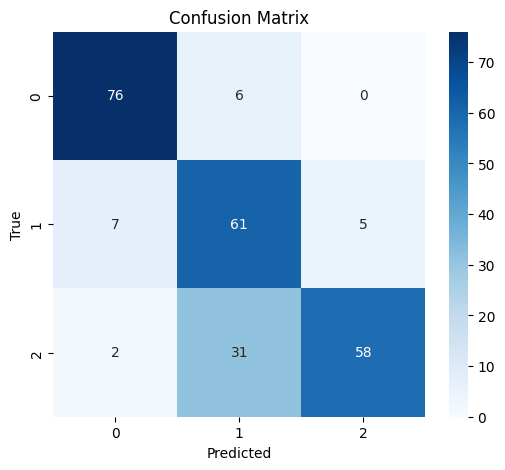

In [ ]:
# Step 10: Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# roBERTa Model 90/10 split

In [ ]:
#  Step 1: Install Dependencies
!pip install transformers torch pandas scikit-learn tqdm openpyxl -q

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
#  Step 2: Import Libraries
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

In [ ]:
#  Step 3: Load Dataset (Upload your Excel file manually)
from google.colab import files
print(" Please upload your Excel file (e.g. MentalHealthTweets.xlsx)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

print(" Dataset Loaded Successfully!")
print(df.head())

📂 Please upload your Excel file (e.g. MentalHealthTweets.xlsx)


Saving MentalHealthTweets.xlsx to MentalHealthTweets.xlsx
✅ Dataset Loaded Successfully!
   Unnamed: 0                                             tweets  label
0           0  be mindful of the timing of your communication...      0
1           1  so why are we suffering disruption today  anxiety      1
2           2  millions of people around the world struggle s...      2
3           3  lets all help to smash the stigma   ptsi  smas...      0
4           4  despair deepens for young people as  pandemic ...      1


In [ ]:
#  Step 4: Preprocess Dataset
df = df.dropna()
texts = df['tweets'].astype(str).tolist()
labels = df['label'].astype(int).tolist()

In [ ]:
# Step 5: Train-Test Split (90/10)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.1, random_state=42, stratify=labels
)


In [ ]:
# Step 6: BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = MentalHealthDataset(train_texts, train_labels, tokenizer)
test_dataset = MentalHealthDataset(test_texts, test_labels, tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#  Step 7: Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#  Step 8: Training Arguments (Fine-tuned for better accuracy)
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to='none' # Explicitly disable reporting to wandb
)

In [ ]:
#  Step 9: Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
# Step 10: Train Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.913316
2,0.263300,1.005216
3,0.263300,1.263188
4,0.100800,1.363531
5,0.100800,1.402298


TrainOutput(global_step=1385, training_loss=0.14186121806340957, metrics={'train_runtime': 533.3917, 'train_samples_per_second': 20.754, 'train_steps_per_second': 2.597, 'total_flos': 728166383562240.0, 'train_loss': 0.14186121806340957, 'epoch': 5.0})

In [ ]:
# Step 11: Evaluate Model
preds_output = trainer.predict(test_dataset)
preds = torch.tensor(preds_output.predictions).argmax(dim=1)

In [ ]:

acc = accuracy_score(test_labels, preds)
print(f" Final Accuracy: {acc * 100:.2f}%")
print("\n Classification Report:\n", classification_report(test_labels, preds))

✅ Final Accuracy: 75.61%

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85        82
           1       0.70      0.54      0.61        82
           2       0.73      0.84      0.78        82

    accuracy                           0.76       246
   macro avg       0.75      0.76      0.75       246
weighted avg       0.75      0.76      0.75       246



# roBERTa model 80/20 split

In [ ]:
#  Step 1: Install Dependencies
!pip install transformers torch pandas scikit-learn tqdm openpyxl -q

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
#  Step 2: Import Libraries
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

In [ ]:
#  Step 3: Load Dataset (Upload your Excel file manually)
from google.colab import files
print(" Please upload your Excel file (e.g. MentalHealthTweets.xlsx)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

print(" Dataset Loaded Successfully!")
print(df.head())

📂 Please upload your Excel file (e.g. MentalHealthTweets.xlsx)


Saving MentalHealthTweets.xlsx to MentalHealthTweets (1).xlsx
✅ Dataset Loaded Successfully!
   Unnamed: 0                                             tweets  label
0           0  be mindful of the timing of your communication...      0
1           1  so why are we suffering disruption today  anxiety      1
2           2  millions of people around the world struggle s...      2
3           3  lets all help to smash the stigma   ptsi  smas...      0
4           4  despair deepens for young people as  pandemic ...      1


In [ ]:
#  Step 4: Preprocess Dataset
df = df.dropna()
texts = df['tweets'].astype(str).tolist()
labels = df['label'].astype(int).tolist()

In [ ]:
#  Step 5: Train-Test Split (80/10)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)


In [ ]:
# Step 6: BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = MentalHealthDataset(train_texts, train_labels, tokenizer)
test_dataset = MentalHealthDataset(test_texts, test_labels, tokenizer)


In [ ]:
#  Step 7: Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#  Step 8: Training Arguments (Fine-tuned for better accuracy)
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to='none' # Explicitly disable reporting to wandb
)

In [ ]:
#  Step 9: Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
#  Step 10: Train Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.597156
2,No log,0.542230
3,0.525000,0.763017
4,0.525000,0.858184
5,0.135500,0.911142


TrainOutput(global_step=1230, training_loss=0.277189373388523, metrics={'train_runtime': 303.3218, 'train_samples_per_second': 32.441, 'train_steps_per_second': 4.055, 'total_flos': 647259007610880.0, 'train_loss': 0.277189373388523, 'epoch': 5.0})

In [ ]:
#  Step 11: Evaluate Model
preds_output = trainer.predict(test_dataset)
preds = torch.tensor(preds_output.predictions).argmax(dim=1)

In [ ]:

acc = accuracy_score(test_labels, preds)
print(f" Final Accuracy: {acc * 100:.2f}%")
print("\n Classification Report:\n", classification_report(test_labels, preds))

✅ Final Accuracy: 79.88%

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       164
           1       0.73      0.69      0.71       164
           2       0.73      0.82      0.77       164

    accuracy                           0.80       492
   macro avg       0.80      0.80      0.80       492
weighted avg       0.80      0.80      0.80       492



roBERTa Large 90/10 split

In [ ]:
!pip install transformers torch pandas scikit-learn openpyxl matplotlib seaborn tqdm --quiet

In [ ]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import files
import io

In [ ]:
print(' Please upload your dataset (MentalHealthTweets.xlsx)')
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[file_name]))
print(' Dataset Loaded Successfully!')
print(df.head())

📂 Please upload your dataset (MentalHealthTweets.xlsx)


Saving tweets_dataset_V-HUMAN.xlsx to tweets_dataset_V-HUMAN.xlsx
✅ Dataset Loaded Successfully!
   Unnamed: 0                                             tweets  label
0           0  be mindful of the timing of your communication...      0
1           1  so why are we suffering disruption today  anxiety      1
2           2  millions of people around the world struggle s...      2
3           3  lets all help to smash the stigma   ptsi  smas...      0
4           4  despair deepens for young people as  pandemic ...      1


In [ ]:
df = df.dropna()
df.columns = df.columns.str.lower()
text_col = 'tweets'
label_col = 'label'
X = df[text_col].astype(str).tolist()
y = df[label_col].astype(int).tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f'Train samples: {len(X_train)}, Test samples: {len(X_test)}')

Train samples: 2214, Test samples: 246


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TweetDataset(X_train, y_train, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(set(y)))
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 5
model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    print(f'Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}')

Epoch 1 Loss: 0.6362


Epoch 2 Loss: 0.3717


Epoch 3 Loss: 0.2543


Epoch 4 Loss: 0.1462


Epoch 5 Loss: 0.0938


In [ ]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
accuracy = accuracy_score(true_labels, predictions)
print(f' Accuracy: {accuracy*100:.2f}%')
print(' Classification Report:')
print(classification_report(true_labels, predictions))

Evaluating: 100%|██████████| 62/62 [00:06<00:00,  8.96it/s]

✅ Accuracy: 79.67%
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        84
           1       0.75      0.55      0.64        74
           2       0.76      0.88      0.81        88

    accuracy                           0.80       246
   macro avg       0.79      0.79      0.78       246
weighted avg       0.79      0.80      0.79       246



roBERTa Large Model 80/20 split

In [ ]:
# Cell 1: Install Libraries
!pip install transformers datasets nlpaug -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.2 MB/s eta 0:00:00


In [ ]:
# Cell 2: Imports
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW # Import AdamW from torch.optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
from tqdm import tqdm
import nlpaug.augmenter.word as naw
import random

In [ ]:
# Cell 3: Load Dataset
# CSV should have columns: 'text', 'label'
from google.colab import files
import io

print(" Please upload your dataset (MentalHealthTweets.xlsx)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print(" Dataset Loaded Successfully!")
print(df.head())

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['tweets'].tolist(), df['label'].tolist(), test_size=0.2, stratify=df['label'], random_state=42
)

📂 Please upload your dataset (MentalHealthTweets.xlsx)


Saving MentalHealthTweets.xlsx to MentalHealthTweets.xlsx
✅ Dataset Loaded Successfully!
   Unnamed: 0                                             tweets  label
0           0  be mindful of the timing of your communication...      0
1           1  so why are we suffering disruption today  anxiety      1
2           2  millions of people around the world struggle s...      2
3           3  lets all help to smash the stigma   ptsi  smas...      0
4           4  despair deepens for young people as  pandemic ...      1


In [ ]:
# Cell 4: Data Augmentation (optional, helps class imbalance)
import nltk
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')

aug = naw.SynonymAug(aug_src='wordnet')
train_texts_aug = []
train_labels_aug = []
for text, label in zip(train_texts, train_labels):
    train_texts_aug.append(text)
    train_labels_aug.append(label)
    if label == 1: # augment minority class
        for _ in range(2):
            augmented_text = aug.augment(text)
            # Ensure augmented_text is a string before appending
            if isinstance(augmented_text, str):
                train_texts_aug.append(augmented_text)
                train_labels_aug.append(label)
            # If augment returns a list, extend the lists
            elif isinstance(augmented_text, list):
                train_texts_aug.extend(augmented_text)
                train_labels_aug.extend(label for _ in range(len(augmented_text)))

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
# Cell 5: Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
MAX_LEN = 512


def tokenize_texts(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt'
    )


train_encodings = tokenize_texts(train_texts_aug)
val_encodings = tokenize_texts(val_texts)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [ ]:
# Cell 6: Custom Dataset
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


train_dataset = TextDataset(train_encodings, train_labels_aug)
val_dataset = TextDataset(val_encodings, val_labels)

In [ ]:
# Cell 7: DataLoader
from torch.utils.data import DataLoader, Dataset
BATCH_SIZE = 8

# START FIX: Copied from a previous cell to resolve NameError: 'train_dataset' is not defined
# Cell 6: Custom Dataset (copied to resolve NameError in this cell)
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels_aug)
val_dataset = TextDataset(val_encodings, val_labels)
# END FIX

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Cell 8: Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-large",
    num_labels=len(set(df["label"]))
)

model = model.to(device)
print(" Model Loaded on:", device)


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔥 Model Loaded on: cuda


In [ ]:
# Cell 9: Optimizer + Scheduler
EPOCHS = 5
LEARNING_RATE = 1e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

loss_fn = CrossEntropyLoss()


In [ ]:
# Cell 10: Training Loop
model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in progress:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        progress.set_postfix({"loss": loss.item()})

    print(f" Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5: 100%|██████████| 410/410 [02:41<00:00,  2.55it/s, loss=0.288]


🟢 Epoch 1 Loss: 0.6444


Epoch 2/5: 100%|██████████| 410/410 [02:39<00:00,  2.56it/s, loss=0.0292]


🟢 Epoch 2 Loss: 0.3076


Epoch 3/5: 100%|██████████| 410/410 [02:39<00:00,  2.56it/s, loss=0.0161]


🟢 Epoch 3 Loss: 0.1832


Epoch 4/5: 100%|██████████| 410/410 [02:39<00:00,  2.56it/s, loss=0.0433]


🟢 Epoch 4 Loss: 0.1185


Epoch 5/5: 100%|██████████| 410/410 [02:39<00:00,  2.57it/s, loss=0.0168]

🟢 Epoch 5 Loss: 0.0725


In [ ]:
# Cell 11: Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f" Final Accuracy: {accuracy*100:.2f}%")

print(" Classification Report:")
print(classification_report(true_labels, predictions))


Evaluating: 100%|██████████| 62/62 [00:03<00:00, 15.82it/s]

✅ Final Accuracy: 80.28%
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       164
           1       0.85      0.55      0.67       164
           2       0.69      0.90      0.78       164

    accuracy                           0.80       492
   macro avg       0.82      0.80      0.80       492
weighted avg       0.82      0.80      0.80       492



<Figure size 600x600 with 0 Axes>

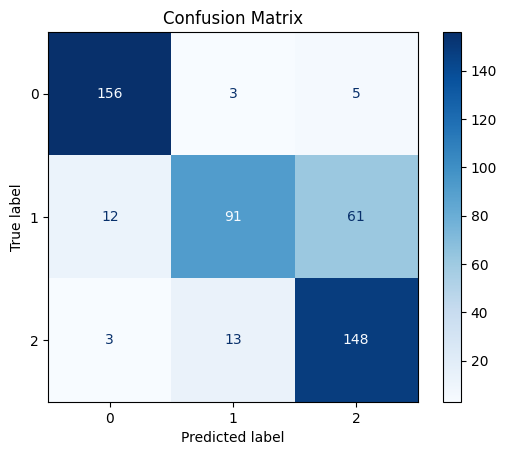

In [ ]:
# -------------------------------------------
# CONFUSION MATRIX FOR BERT CLASSIFIER
# -------------------------------------------

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# DistilBERT Model Training

In [ ]:
!pip install transformers datasets scikit-learn torch --quiet


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW # Corrected import for AdamW
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import files
import io

print(" Please upload your dataset (MentalHealthTweets.xlsx)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]

# Load the dataset using the actual uploaded file and format
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

# Now create a dummy csv from the dataframe to be loaded by datasets.load_dataset
df.to_csv('MentalHealthTweets.csv', index=False)

dataset = load_dataset("csv", data_files="MentalHealthTweets.csv")
dataset = dataset["train"].train_test_split(test_size=0.2)
train_data = dataset["train"]
test_data = dataset["test"]

train_data, test_data

📂 Please upload your dataset (MentalHealthTweets.xlsx)


Saving MentalHealthTweets.xlsx to MentalHealthTweets (1).xlsx


Generating train split: 0 examples [00:00, ? examples/s]

(Dataset({
     features: ['Unnamed: 0', 'tweets', 'label'],
     num_rows: 1968
 }),
 Dataset({
     features: ['Unnamed: 0', 'tweets', 'label'],
     num_rows: 492
 }))

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch["tweets"], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1968 [00:00<?, ? examples/s]

Map:   0%|          | 0/492 [00:00<?, ? examples/s]

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(train_data['label']))
).to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} — Loss: {total_loss/len(train_dataloader)}")


Epoch 1 — Loss: 3.9505665457345605
Epoch 2 — Loss: 0.7298946545376042
Epoch 3 — Loss: 0.43308123885616057
Epoch 4 — Loss: 0.30014233969575993
Epoch 5 — Loss: 0.19686883648600034


In [ ]:
from tqdm import tqdm

model.eval()
preds = []
true_labels = []

print("Evaluating:")

for batch in tqdm(test_dataloader):
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(true_labels, preds)
print(f" Final Accuracy: {acc * 100:.2f}%")

# Classification Report
print(" Classification Report:")
print(classification_report(true_labels, preds))


Evaluating:


100%|██████████| 31/31 [00:01<00:00, 18.06it/s]

✅ Final Accuracy: 77.03%
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       165
           1       0.71      0.64      0.67       170
           2       0.73      0.78      0.75       157

    accuracy                           0.77       492
   macro avg       0.77      0.77      0.77       492
weighted avg       0.77      0.77      0.77       492



In [ ]:
# DistilBERT MODEL IN 90/10 SPLIT

In [ ]:
!pip install transformers datasets scikit-learn torch --quiet


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW # Corrected import for AdamW
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import files
import io
import pandas as pd # Added this import statement
from datasets import load_dataset

print(" Please upload your dataset (MentalHealthTweets.xlsx or .csv file)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]

# Load the dataset using the actual uploaded file and format
if file_name.endswith('.xlsx'):
    df = pd.read_excel(io.BytesIO(uploaded[file_name]))
elif file_name.endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
else:
    raise ValueError("Unsupported file format. Please upload an .xlsx or .csv file.")

# Now create a dummy csv from the dataframe to be loaded by datasets.load_dataset
df.to_csv('MentalHealthTweets.csv', index=False)

dataset_from_csv = load_dataset("csv", data_files="MentalHealthTweets.csv")
splits = dataset_from_csv["train"].train_test_split(test_size=0.1)
train_data = splits["train"]
test_data = splits["test"]

train_data, test_data

📂 Please upload your dataset (MentalHealthTweets.xlsx or .csv file)


Saving tweets_dataset_V-HUMAN.xlsx to tweets_dataset_V-HUMAN.xlsx


Generating train split: 0 examples [00:00, ? examples/s]

(Dataset({
     features: ['Unnamed: 0', 'tweets', 'label'],
     num_rows: 2214
 }),
 Dataset({
     features: ['Unnamed: 0', 'tweets', 'label'],
     num_rows: 246
 }))

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch["tweets"], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/2214 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(train_data['label']))
).to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} — Loss: {total_loss/len(train_dataloader)}")


Epoch 1 — Loss: 3.816946735056184
Epoch 2 — Loss: 0.6625695126734191
Epoch 3 — Loss: 0.41650463345882704
Epoch 4 — Loss: 0.27658524648319904
Epoch 5 — Loss: 0.15698933109587473


In [ ]:
from tqdm import tqdm

model.eval()
preds = []
true_labels = []

print("Evaluating:")

for batch in tqdm(test_dataloader):
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(true_labels, preds)
print(f" Final Accuracy: {acc * 100:.2f}%")

# Classification Report
print(" Classification Report:")
print(classification_report(true_labels, preds))


Evaluating:


100%|██████████| 16/16 [00:00<00:00, 18.12it/s]

✅ Final Accuracy: 78.86%
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        89
           1       0.74      0.69      0.71        89
           2       0.74      0.79      0.77        68

    accuracy                           0.79       246
   macro avg       0.78      0.79      0.79       246
weighted avg       0.79      0.79      0.79       246



In [ ]:
# DistilBERT with 90/10 split and curves

In [ ]:
!pip install transformers datasets scikit-learn torch --quiet


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import io
from google.colab import files


In [ ]:
print(" Please upload your dataset (MentalHealthTweets.xlsx or .csv)")

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Load file according to format
if file_name.endswith('.xlsx'):
    df = pd.read_excel(io.BytesIO(uploaded[file_name]))
elif file_name.endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[file_name]))
else:
    raise ValueError("Unsupported file format. Upload .xlsx or .csv")

df.to_csv("MentalHealthTweets.csv", index=False)

dataset_from_csv = load_dataset("csv", data_files="MentalHealthTweets.csv")
splits = dataset_from_csv["train"].train_test_split(test_size=0.1)

train_data = splits["train"]
test_data = splits["test"]

train_data, test_data


📂 Please upload your dataset (MentalHealthTweets.xlsx or .csv)


Saving tweets_dataset_V-HUMAN.xlsx to tweets_dataset_V-HUMAN.xlsx


Generating train split: 0 examples [00:00, ? examples/s]

(Dataset({
     features: ['Unnamed: 0', 'tweets', 'label'],
     num_rows: 2214
 }),
 Dataset({
     features: ['Unnamed: 0', 'tweets', 'label'],
     num_rows: 246
 }))

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["tweets"], padding="max_length", truncation=True, max_length=128)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/2214 [00:00<?, ? examples/s]

Map:   0%|          | 0/246 [00:00<?, ? examples/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(train_data['label']))
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_losses = []
train_accuracies = []


In [ ]:
from tqdm import tqdm

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%")


Epoch 1 — Loss: 3.8635, Accuracy: 52.85%
Epoch 2 — Loss: 0.6944, Accuracy: 75.34%
Epoch 3 — Loss: 0.4447, Accuracy: 82.93%
Epoch 4 — Loss: 0.3007, Accuracy: 88.53%
Epoch 5 — Loss: 0.1911, Accuracy: 93.86%


In [ ]:
model.eval()
preds = []
true_labels = []

print("Evaluating:")

for batch in tqdm(test_dataloader):
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, preds)
print(f" Final Accuracy: {acc * 100:.2f}%")

print(" Classification Report:")
print(classification_report(true_labels, preds))


Evaluating:


100%|██████████| 16/16 [00:00<00:00, 18.10it/s]

✅ Final Accuracy: 82.11%
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        95
           1       0.69      0.77      0.73        75
           2       0.86      0.75      0.80        76

    accuracy                           0.82       246
   macro avg       0.82      0.81      0.81       246
weighted avg       0.83      0.82      0.82       246



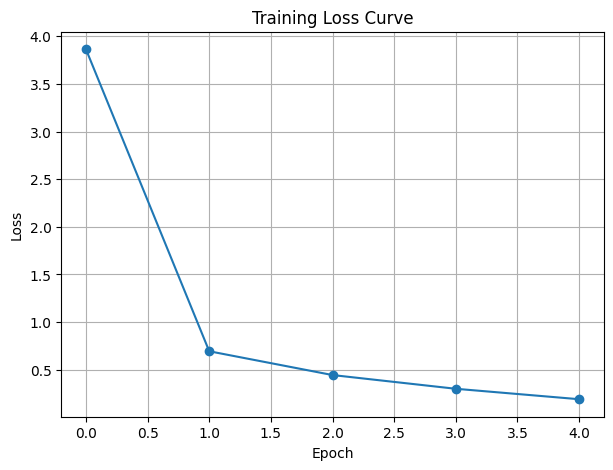

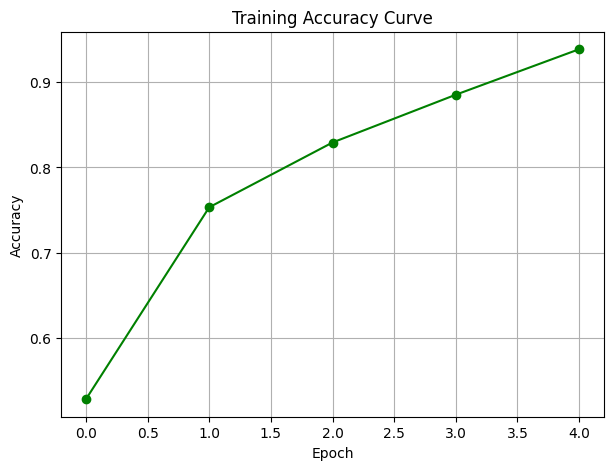

In [ ]:
# Loss Curve
plt.figure(figsize=(7,5))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(7,5))
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [ ]:
report = classification_report(true_labels, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print(" Table for each sentiment class:")
df_report


📋 Table for each sentiment class:


,precision,recall,f1-score,support
0,0.906250,0.915789,0.910995,95.000000
1,0.690476,0.773333,0.729560,75.000000
2,0.863636,0.750000,0.802817,76.000000
accuracy,0.821138,0.821138,0.821138,0.821138
macro avg,0.820121,0.813041,0.814457,246.000000
weighted avg,0.827300,0.821138,0.822258,246.000000


In [ ]:
df_report.to_csv("sentiment_metrics.csv")
print("Saved → sentiment_metrics.csv")


Saved → sentiment_metrics.csv


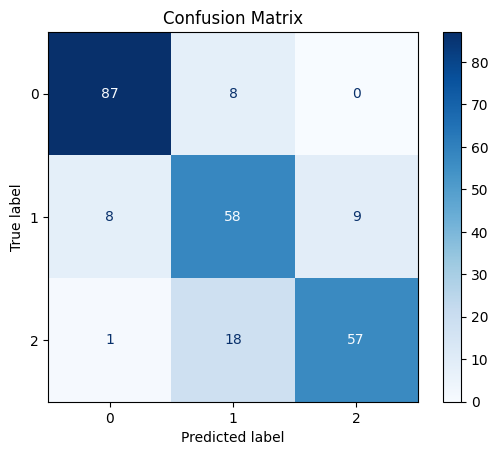

In [ ]:
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
